Digital Business University of Applied Sciences

Data Science und Management (M. Sc.)

MALE01 Machine Learning

Prof. Dr. Daniel Ambach

Julia Schmid (200022)

***
# Vergleich datenbasierter und modellbasierte Methoden zur Behebung unausgeglichener Datensätze hinsichtlich der Vorhersageleistung und Fairness in Klassifikationsmodellen des maschinellen Lernens
***

**Problemstellung**

In Datensätzen tritt häufig das Problem einer starken Ungleichverteilung der Zielvariablen auf. Dies kann unterschiedliche Ursachen haben, wie etwa natürliche Häufigkeiten oder fehlerhafte Datenerhebung. Es kann vorkommen, dass in der Minderheitsklasse wichtige Informationen, wie beispielsweise seltene medizinische Diagnosen, enthalten. Die Folgen einer ungleichmäßigen Klassenverteilung sind verzerrte Ergebnisse, wodurch bestimmte Gruppen systematisch benachteiligt werden und somit die Fairness des Modells beeinträchtigen.

In [1]:
# Importe
# Standardbibliotheken
import os
import pandas as pd 
from collections import Counter
import numpy as np

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Profilingreport
from ydata_profiling import ProfileReport
import webbrowser

# Modelle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Metriken
from sklearn.metrics import (f1_score, roc_auc_score,roc_curve, auc, balanced_accuracy_score)
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Sampling Methoden
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE


**Datenauswahl**

Für den Vergleich der datenbasierten und algorithmusbasierten Methoden wurde der Datensatz Give Me Some Credit (Fusion & Cukierski, 2011) von Kaggle verwendet. Dieser Datensatz umfasst zwölf Variablen mit verschiedenen Kreditinformationen von 150.000 Bankkunden. Die Zielvariable SeriousDlqin2yrs gibt an, ob innerhalb von zwei Jahren ein Zahlungsverzug von mindestens 90 Tagen eingetreten ist. Dabei ist die Klasse "kein Zahlungsausfall" deutlich überrepräsentiert im Vergleich zur Klasse "Zahlungsausfall". Aufgrund dieser Ungleichverteilung eignet sich der Datensatz besonders gut, um datenbasierte und modellbasierte Methoden anzuwenden, zu evaluieren und miteinander zu vergleichen.

| **Variablenname**                         | **Erklärung Variable**                                                                                   |
|--------------------------------------------|----------------------------------------------------------------------------------------------------------|
| SeriousDlqin2yrs                           | Zielvariable: Zahlungsverzug von 90 Tage oder länger                                                     |
| RevolvingUtilizationOfUnsecuredLines       | Gesamter ausstehender Betrag auf Kreditkarten und persönlichen Krediten (ohne Immobilien- und Ratenkredite) |
| age                                        | Alter                                                                                                    |
| NumberOfTime30 59DaysPastDueNotWorse        | Anzahl der 30 bis 59 Tage überfälligen Zahlungen in den letzten zwei Jahren                              |
| DebtRatio                                  | Verhältnis von monatlichen Schuldenzahlungen zum Bruttoeinkommen                                         |
| MonthlyIncome                              | Monatliches Einkommen                                                                                   |
| NumberOfOpenCreditLinesAndLoans            | Anzahl der offenen Kredite und Kreditlinien                                                              |
| NumberOfTimes90DaysLate                    | Anzahl der Fälle, in denen 90 Tage oder länger ein Verzug vorliegt                                        |
| NumberRealEstateLoansOrLines               | Anzahl der Immobilienkredite                                                                             |
| NumberOfTime60 89DaysPastDueNotWorse        | Anzahl der 60 bis 89 Tage überfälligen Zahlungen in den letzten zwei Jahren                              |
| NumberOfDependents                         | Anzahl der unterhaltsberechtigten Personen in der Familie                                                |

(Fusion & Cukierski, 2011)


## **Daten verstehen** 

### Daten einlesen

In [2]:
input_file_name = "input/cs-training.csv"
df = pd.read_csv(input_file_name, encoding='latin1', index_col=0)

### Daten beschreiben

In [3]:
# Ausgabe der ersten 5 Zeilen
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
# Ausgabe der Anzahl der Zeilen und Spalten
print(f'Anzahl Zeilen: {df.shape[0]}')
print(f'Anzahl Spalten: {df.shape[1]}')

Anzahl Zeilen: 150000
Anzahl Spalten: 11


In [5]:
# Ausgabe der Datensatz-Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

In [6]:
# Ausgabe der numerischen und kategorischen Variablen 
numericalVar = [col for col in df if df[col].dtype != 'object']
print(numericalVar)

categoricalVar = [col for col in df if df[col].dtype == 'object']
print(categoricalVar)

['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
[]


In [7]:
# Ausgabe der statistischen Kennzahlen der numerischen Variablen
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


### Daten visualisieren

In [8]:
# Erstellung eines Profilingreports
pr = ProfileReport(df, title = 'Credit Data') 
filename_pr = "output/credit_data_pr.html" 
path_pr = os.path.abspath(filename_pr) 

pr.to_file(path_pr)  # ProfileReport als HTML speichern
webbrowser.open(f"file://{path_pr}")  # ProfileReport im Browser öffnen

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 14.94it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

True

## **Datenaufbereitung**

Aus dem Abschnitt "Daten verstehen" geht hervor, dass alle Variablen numerisch sind und somit keine Transformation benötigen. 
Ferner wird der Datensatz auf Duplikate und NaN-Werte geprüft und bereinigt.
Die Duplikate werden gelöscht, wie auch die NaN-Werte, da hierzu keine geeigneten Informationen zur Imputation vorhanden sind.
Vor dem Hintergrund, dass die Modellergebnisse auf ihre Fairness geprüft wird, wird die Spalte Age in zwei Kategorien (jung/alt) geteilt.

### Duplikate

In [9]:
# Bestimmung der Anzahl der Duplikate
df_duplicates = df[df.duplicated()]
print(f'Dieser Datensatz besitz {len(df_duplicates)} Duplikate.')

# Bestimmung der Anzahl der Duplikate pro Klasse
duplicates_per_class = df_duplicates['SeriousDlqin2yrs'].value_counts()
print(f'Von den Duplikaten liegen {duplicates_per_class.get(0, 0)} Instanzen in der Klasse "kein Zahlungsausfall" (0) und {duplicates_per_class.get(1, 0)} Instanzen in der Klasse "Zahlungsausfall" (1)')

Dieser Datensatz besitz 609 Duplikate.
Von den Duplikaten liegen 592 Instanzen in der Klasse "kein Zahlungsausfall" (0) und 17 Instanzen in der Klasse "Zahlungsausfall" (1)


In [10]:
# Duplikate werden gelöscht
df = df.drop_duplicates()

### NaNs

In [11]:
# Bestimmung der Variablen mit Nan-Werte mit der Anzahl der NaN-Einträge
df.isnull().sum()[df.isnull().sum() > 0]

MonthlyIncome         29221
NumberOfDependents     3828
dtype: int64

In [12]:
# Zeilen mit NaN-Werten werden gelöscht, da keine Informationen darüber vorliegen, wie die fehlenden Werte sinnvoll rekonstruiert werden könnten.
df = df.dropna(subset=['MonthlyIncome'])
df = df.dropna(subset=['NumberOfDependents'])

### Kategorie Alter erstellen

In [13]:
# Spalte Age in zwei Kategorien teilen jung/alt
df['age_categories'] = pd.cut(df['age'], bins=[0, 50, float('inf')], labels=[0, 1], right=False) # 0 = young, 1 = old
df['age_categories'] = df['age_categories'].cat.codes
print(df['age_categories'].value_counts())
print('')
print(pd.crosstab(df['age_categories'], df['SeriousDlqin2yrs']))

age_categories
1    63718
0    56452
Name: count, dtype: int64

SeriousDlqin2yrs      0     1
age_categories               
0                 51206  5246
1                 60609  3109


## **Machine Learning Modellierung** 

Für das Training von Klassifikationsmodelle werden die supervised ML Modelle RF, LR und XGBoost verwendet. Diese drei Modelle repräsentieren unterschiedliche Modelltypen, zeichnen sich durch ihre bewährte Leistungsfähigkeit aus und ermöglichen eine gezielte Anpassung der Hyperparameter (HP) auf Modellebene.

### Funktionen für das Training und der Evaluierung der ML-Modelle



In [14]:
# Ergebnistabelle initialisieren (für die Speicherung der Evaluationskennzahlen)
df_result = pd.DataFrame(columns=['model','method', 'balancedAccuracy', 'f1', 'rocAuc', 'dir', 'eo'])

'''
Funktion:       Ermittlung des Disperate Impact Ratio Wertes.
Input:          y_pred (vom Modell vorhergesagte Zielvariable)
                age_test (Werte des zu prüfenden Age Attributs)
Output:         dri (ermittelter Disperate Impact Ratio Wert)
Funktionsweise: Gemäß der Definition (DIR = P(Ŷ = 1 | A = 1) / P(Ŷ = 1 | A = 0) mit A = 1 geschütze Gruppe und A = 0 Referenzgruppe) wird der Disperate Impact Ratio Wert ermittelt. 
'''
def getDisparateImpact(y_pred, age_test):
    prop_young = y_pred[age_test == 0].mean() # P(Ŷ=1|A=young)
    prop_old = y_pred[age_test == 1].mean() # P(Ŷ=1|A=old)

    if prop_old == 0: # Divison durch 0 verhindern
        return np.nan 
    
    dir = prop_old / prop_young
    return dir


'''
Funktion:       Training auf den Trainingsdaten und Vorhersage der Zielvariable auf den Testdaten für das übergebene Modell.
Input:          ml_model (ausgewähltes zu trainierenden Modell), 
                X_train (Label der Trainingsdaten), 
                y_train (Feature der Trainingsdaten), 
                X_test (Label der Testdaten), 
                name (Name des zu trainierenden Modells), 
                algoAdaption (Variable, welche angibt, ob eine Klassen-Gewichtung bestimmt werden soll)
                threshold (Schwellenwert für die Zuordnung einer Beobachtung zu einer bestimmeten Klasse)
Output:         y_pred_model (vom Modell vorhergesagte Zielvariable)
Funktionsweise: Das übergebende Modell wird auf den Trainingsdaten trainiert und eine Vorhersage für die Testdaten getroffen. '
'''
def runModel(ml_model, X_train, y_train, X_test, name, algoAdaption = False, threshold = 0.5):
    name_print_out = name
    print('[INFO] Model ' + name_print_out + ' started.') # Info-Meldung: Modelltraining Start

    # Modell-Name
    name = name.split()[0]
    name = name.replace(" ", "")

    sampleWeights = compute_sample_weight(class_weight='balanced', y=y_train) if algoAdaption else None # Gewichtigung für das Training
    ml_model.fit(X_train, y_train, sample_weight = sampleWeights) # Modell Training mit Trainings-daten 
    
    # Für die Testdaten wird eine Vorhersage basierend auf dem trainierten Modell getroffen:
    y_proba = ml_model.predict_proba(X_test)[:, 1] 
    y_pred_model = (y_proba >= threshold).astype(int)

    print('[INFO] Model ' + name_print_out + ' finished.') # Info-Meldung: Modelltraining Ende

    return(y_pred_model)

'''           
Funktion:       Bestimmung der Evaluationskenntzahlen für das übergebende Modell 
Input:          y_pred_model (vorhergesagte Zielvariable), 
                y_test (tatsächlicher Zielvariable), 
                age_test (Test-Daten der kategorischen Age-Spalte),
                name (Name des trainierte Modell), 
                df_result (Ergebnistabelle), 
                method (Methode zur Behebung unausgeglichener Daten)
Output:         df_result (angepasste Ergebnistabelle), 
                (fpr, tpr, rocAuc) (ROC-Daten)
Funktionsweise: Mithilfe der vorhergesagten und der tatsächlichen Zielvariablen wird die Balanced Accuracy, Precision, Recall, F1, ROC-AUC, FPR und TPR ermittelt. 
                Die ermittelten Kennzahlen und die Fairness-Kennzhalen werden in der Ergebistabelle mit dem Modellname und der Methodenname gespeichert.
'''

def getResults(y_pred_model, y_test, age_test, name, df_result, method):
    # Bestimmung der Leistungskennzahlen
    balancedAccuracy = balanced_accuracy_score(y_test, y_pred_model)
    f1 = f1_score(y_test, y_pred_model)
    rocAuc = roc_auc_score(y_test, y_pred_model)
    fpr, tpr, _ = roc_curve(y_test, y_pred_model)
    rocAuc = auc(fpr, tpr)

    # Bestimmung der Fairnessmetriken
    disparate_impact_ratio = getDisparateImpact(y_pred_model, age_test) # Bestimmung der Kennzahl Disperate Impact Ratio
    equal_opportunity = equalized_odds_difference(y_test, y_pred_model, sensitive_features=age_test)

    # Speicherung der Kennzahlen 
    temp = pd.DataFrame([[name.split()[0], method, balancedAccuracy, f1,rocAuc, disparate_impact_ratio, equal_opportunity ]], columns=['model','method','balancedAccuracy', 'f1', 'rocAuc','dir', 'eo'])
    df_result = pd.concat([df_result, temp], ignore_index=True)

    return df_result, (fpr, tpr, rocAuc)

'''
Funktion:       Definierung der ML-Modelle inkl. Methode-Besonderheiten sowie Training und Evaluierung der Modelle
Input:          X_train (Label der Trainingsdaten), 
                y_train (Feature der Trainingsdaten), 
                X_test (Label der Testdaten), 
                y_test (tatsächlicher Zielvariable), 
                age_test (Test-Daten der kategorischen Age-Spalte),
                df_result (Ergebnistabelle), 
                method (Methode zur Behebung unausgeglichener Daten), 
                balanced (Gewicht-Parameter-Wert), 
                algo (Boolean-Wert der angibt, ob es sich um die Anpassung der Parameter Methode handelt)
                threshold (Schwellenwert für die Zuordnung einer Beobachtung zu einer bestimmeten Klasse)
Output:         df_result (angepasste Ergebnistabelle), 
                roc_data_dict (ROC-Daten)
Funktionsweise: Abhängig von der Anpassung der Parameter Methode wird das Klassenverhätlnis für das XGBoost-Modell bestimmt. 
                Anschließend werden die Modelle mit ihren Methode-Besonderheiten definiert. Jedes Modell wird trainiert, getestet und evaluiert aauf die Modellleistung und Fairness.
'''
def runAndPredict(X_train, y_train, X_test, y_test, age_test,  df_result, method, balanced = None, algo = False, threshold = 0.5):
    # Bei der Methode der Anpassung der Parameter wird das Verhältnis der beiden Zielvariablenklassen (0,1) bestimmt. 
    # Bei allen anderen Methoden wird keine Verhältnis bestimmt und auf 1 gesetzt.
    ratio = 1 if algo == False else (sum(y_train == 0) / sum(y_train == 1))
    if(ratio != 1):
        print(f'Das Klassenverhältnis beträgt: {ratio}')

    # Definierung der drei ML-Grundmodelle
    rf_model = RandomForestClassifier(random_state=123, class_weight = balanced)
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric = 'auc', random_state=123, n_estimators=500, learning_rate=0.2, scale_pos_weight=ratio )
    logReg_model = LogisticRegression(class_weight=balanced)

    # Zuordnung zwischen Modell-Name (mit Methoden-Besonderheit) und Modell
    ml_model = {
        f'RF {method}': rf_model,
        f'XGBoost {method}': xgb_model,
        f'LR {method}': logReg_model
    }
    
    roc_data_dict = {}

    # Jedes Model wird trainiert und evaluiert
    for modelName, model in ml_model.items():
        y_pred = runModel(model, X_train, y_train, X_test, modelName, threshold = threshold) # Training und Vorhersage der Zievariable auf Testdaten

        df_result, roc_data = getResults(y_pred, y_test, age_test,  modelName, df_result, method) # Evaluierung 
        roc_data_dict[modelName] = roc_data # Speicherung der ROC-Daten

    return df_result, roc_data_dict

### Daten in Test- und Trainingsdaten teilen

In [15]:
# Ausgabe der Verteilung der Zielvariable SeriousDlqin2yrs
count_label = df['SeriousDlqin2yrs'].value_counts()
count_label

SeriousDlqin2yrs
0    111815
1      8355
Name: count, dtype: int64

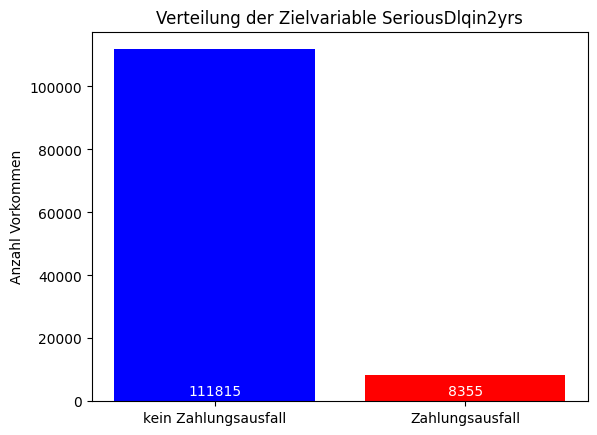

In [16]:
# Grafik: Verteilung der Zielvariable SeriousDlqin2yrs
plt.bar(count_label.index, count_label.values, color=['blue', 'red'])
plt.xlabel('')
plt.ylabel('Anzahl Vorkommen')
plt.title('Verteilung der Zielvariable SeriousDlqin2yrs')
plt.xticks(ticks=[0, 1], labels=["kein Zahlungsausfall", "Zahlungsausfall"])
y_text_position = min(count_label.values) * 0.1
for i, v in enumerate(count_label.values):
    plt.text(i, y_text_position, str(v), ha='center', va='bottom', color='white', fontsize=10)
plt.savefig("output/distribution_targetVariable.png", dpi=300, bbox_inches="tight") # Grafik speichern
plt.show()

In [17]:
# Daten im Verhätlnis 80%-20% (Training-Test) aufteilen
X = df.drop(columns=['SeriousDlqin2yrs', 'age_categories'])
y = df['SeriousDlqin2yrs']
age = df['age_categories']

X_train, X_test, y_train, y_test, age_train, age_test = train_test_split(X, y, age, test_size=0.2, random_state=123)


In [18]:
# Skalierung 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Basismodell**

In [19]:
# Anwendung der Funktion runAndPredict ohne Anpassungenm 
df_result, roc_data = runAndPredict(X_train_scaled, y_train, X_test_scaled, y_test, age_test, df_result, 'Baseline' )

[INFO] Model RF Baseline started.
[INFO] Model RF Baseline finished.
[INFO] Model XGBoost Baseline started.


/var/folders/jf/k1y_jzxs5177jm_fgv__dnww0000gn/T/ipykernel_60607/1373474357.py:81: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, temp], ignore_index=True)


[INFO] Model XGBoost Baseline finished.
[INFO] Model LR Baseline started.
[INFO] Model LR Baseline finished.


### **Datenebene**

### Undersampling

#### Random Undersampling

In [20]:
# Undersampling durchführen
print('Ursprüngliche Klassenvertilung %s' % Counter(y))

rus = RandomUnderSampler(random_state=123)
X_rus, y_rus = rus.fit_resample(X, y)

selected_indices = rus.sample_indices_
age_rus = age.reset_index(drop=True).iloc[selected_indices].reset_index(drop=True)

print('Neue Klassenverteilung mit Undersampling:', Counter(y_rus))
X_train_rus, X_test_rus, y_train_rus, y_test_rus, age_rus_train, age_rus_test = train_test_split(X_rus, y_rus, age_rus, test_size=0.2, random_state=123)

Ursprüngliche Klassenvertilung Counter({0: 111815, 1: 8355})
Neue Klassenverteilung mit Undersampling: Counter({0: 8355, 1: 8355})


In [21]:
# Skalierung 
scaler = StandardScaler()
X_train_rus_scaled = scaler.fit_transform(X_train_rus)
X_test_rus_scaled = scaler.transform(X_test_rus)

In [22]:
# Anwendung der Funktion runAndPredict mit Undersampling
df_result, roc_data_rus = runAndPredict(X_train_rus_scaled, y_train_rus, X_test_rus_scaled, y_test_rus, age_rus_test,  df_result, 'RUS')

[INFO] Model RF RUS started.
[INFO] Model RF RUS finished.
[INFO] Model XGBoost RUS started.
[INFO] Model XGBoost RUS finished.
[INFO] Model LR RUS started.
[INFO] Model LR RUS finished.


#### Tomek Links

In [23]:
print('Ursprüngliche Klassenvertilung %s' % Counter(y))

tl = TomekLinks(sampling_strategy='majority')  # Nur Mehrheitsklasse wird reduziert
X_train_tl, y_train_tl = tl.fit_resample(X_train, y_train)

print('Neue Klassenverteilung mit Tomek Links:', Counter(y_train_tl))

Ursprüngliche Klassenvertilung Counter({0: 111815, 1: 8355})
Neue Klassenverteilung mit Tomek Links: Counter({0: 87222, 1: 6702})


In [24]:
# Skalierung 
scaler = StandardScaler()
X_train_tl_scaled = scaler.fit_transform(X_train_tl)
X_test_tl_scaled = scaler.transform(X_test)

In [25]:
# Anwendung der Funktion runAndPredict mit Tomek Links
df_result, roc_data_tl = runAndPredict(X_train_tl_scaled, y_train_tl, X_test_tl_scaled, y_test, age_test, df_result, 'TL')

[INFO] Model RF TL started.
[INFO] Model RF TL finished.
[INFO] Model XGBoost TL started.
[INFO] Model XGBoost TL finished.
[INFO] Model LR TL started.
[INFO] Model LR TL finished.


### Oversampling

#### Random Undersampling

In [26]:
# Oversampling durchführen 
print('Ursprüngliche Klassenvertilung %s' % Counter(y))

ros = RandomOverSampler(sampling_strategy='minority')
X_ros, y_ros = ros.fit_resample(X, y)

selected_indices = ros.sample_indices_
age_ros = age.reset_index(drop=True).iloc[selected_indices].reset_index(drop=True)

print('Neue Klassenverteilung mit Undersampling:', Counter(y_ros))
X_train_ros, X_test_ros, y_train_ros, y_test_ros, age_ros_train, age_ros_test = train_test_split(X_ros, y_ros, age_ros, test_size=0.2, random_state=123)

Ursprüngliche Klassenvertilung Counter({0: 111815, 1: 8355})
Neue Klassenverteilung mit Undersampling: Counter({1: 111815, 0: 111815})


In [27]:
# Skalierung 
scaler = StandardScaler()
X_train_ros_scaled = scaler.fit_transform(X_train_ros)
X_test_ros_scaled = scaler.transform(X_test_ros)

In [28]:
# Anwendung der Funktion runAndPredict mit Oversampling
df_result, roc_data_ros = runAndPredict(X_train_ros_scaled, y_train_ros, X_test_ros_scaled, y_test_ros,age_ros_test, df_result, 'ROS' )

[INFO] Model RF ROS started.
[INFO] Model RF ROS finished.
[INFO] Model XGBoost ROS started.
[INFO] Model XGBoost ROS finished.
[INFO] Model LR ROS started.
[INFO] Model LR ROS finished.


#### SMOTE

In [29]:
# SMOTE durchführen
print('Ursprüngliche Klassenvertilung %s' % Counter(y))

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Neue Klassenverteilung mit SMOTE:', Counter(y_train_smote))


Ursprüngliche Klassenvertilung Counter({0: 111815, 1: 8355})
Neue Klassenverteilung mit SMOTE: Counter({0: 89434, 1: 89434})


In [30]:
# Skalierung 
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_smote_scaled = scaler.transform(X_test)

In [31]:
# Anwendung der Funktion runAndPredict mit SMOTE
df_result, roc_data_smote = runAndPredict(X_train_smote_scaled, y_train_smote, X_test_smote_scaled, y_test, age_test, df_result, 'SMOTE')

[INFO] Model RF SMOTE started.
[INFO] Model RF SMOTE finished.
[INFO] Model XGBoost SMOTE started.
[INFO] Model XGBoost SMOTE finished.
[INFO] Model LR SMOTE started.
[INFO] Model LR SMOTE finished.


### **Modellebene** 

#### Anpassung der Hyperparameter

In [32]:
# Anwendung der Funktion runAndPredict mit angepassten Hyperparameter 
df_result, roc_data_hp = runAndPredict(X_train_scaled, y_train, X_test_scaled, y_test, age_test, df_result, 'HP', balanced = "balanced",algo = True )

Das Klassenverhältnis beträgt: 13.34437481348851
[INFO] Model RF HP started.
[INFO] Model RF HP finished.
[INFO] Model XGBoost HP started.
[INFO] Model XGBoost HP finished.
[INFO] Model LR HP started.
[INFO] Model LR HP finished.


#### Threshold Moving

In [33]:
# Anwendung der Funktion runAndPredict mit angepassten Treshold
df_result, roc_data_tm = runAndPredict(X_train_scaled, y_train, X_test_scaled, y_test, age_test, df_result, 'TM', threshold = 0.3)

[INFO] Model RF TM started.
[INFO] Model RF TM finished.
[INFO] Model XGBoost TM started.
[INFO] Model XGBoost TM finished.
[INFO] Model LR TM started.
[INFO] Model LR TM finished.


## **Evaluation**

### Vergleich der Evaluationskennzahlen (Tabelle)

In [34]:
df_result = df_result.sort_values(by=['method', 'model'])
df_result

,model,method,balancedAccuracy,f1,rocAuc,dir,eo
2,LR,Baseline,0.514433,0.058990,0.514433,0.237513,0.021948
0,RF,Baseline,0.588691,0.278392,0.588691,0.358544,0.070070
1,XGBoost,Baseline,0.591908,0.284229,0.591908,0.421009,0.059426
17,LR,HP,0.721598,0.313108,0.721598,0.239406,0.295072
15,RF,HP,0.572554,0.239963,0.572554,0.325333,0.075866
16,XGBoost,HP,0.713070,0.349628,0.713070,0.397717,0.158258
11,LR,ROS,0.726705,0.693801,0.726705,0.408191,0.261748
9,RF,ROS,0.985419,0.985548,0.985419,0.701939,0.027802
10,XGBoost,ROS,0.901026,0.903216,0.901026,0.675636,0.108127
5,LR,RUS,0.723811,0.688114,0.723811,0.405444,0.252810


In [35]:
# Pro Kennzahl wird die beste Methoden-Modell Kombination bestimmt

df_result['ModelKind'] = df_result['model'] + '-' + df_result['method']

# Ausgabe der besten Methode pro Kennzahl
for i in ['balancedAccuracy',  'f1', 'rocAuc', 'dir', 'eo']:
    if i == 'eo':
       min_value_row = df_result.loc[df_result[i].idxmin()]  # Bestimme Zeile mit Minimalen-Wert
       min_value_kind = min_value_row['ModelKind'] 
       print(f"Minimaler Wert {i} = {min_value_row[i]} beim Modell {min_value_kind}.")
    else:
        max_value_row = df_result.loc[df_result[i].idxmax()]  # Bestimme Zeile mit Maximalen-Wert
        max_value_kind = max_value_row['ModelKind']
        print(f"Maximale Wert {i} = {max_value_row[i]} beim Modell {max_value_kind}.")


Maximale Wert balancedAccuracy = 0.9854187104253991 beim Modell RF-ROS.
Maximale Wert f1 = 0.9855482388297168 beim Modell RF-ROS.
Maximale Wert rocAuc = 0.9854187104253991 beim Modell RF-ROS.
Maximale Wert dir = 0.7019394760846154 beim Modell RF-ROS.
Minimaler Wert eo = 0.021948287168597574 beim Modell LR-Baseline.


### Vergleich der Evaluationskennzahlen (Grafiken)

# 

In [36]:
# Methoden-Liste
resampling_methods = ["Baseline", "RUS", "TL",  "ROS", "SMOTE", "HP", "TM"]

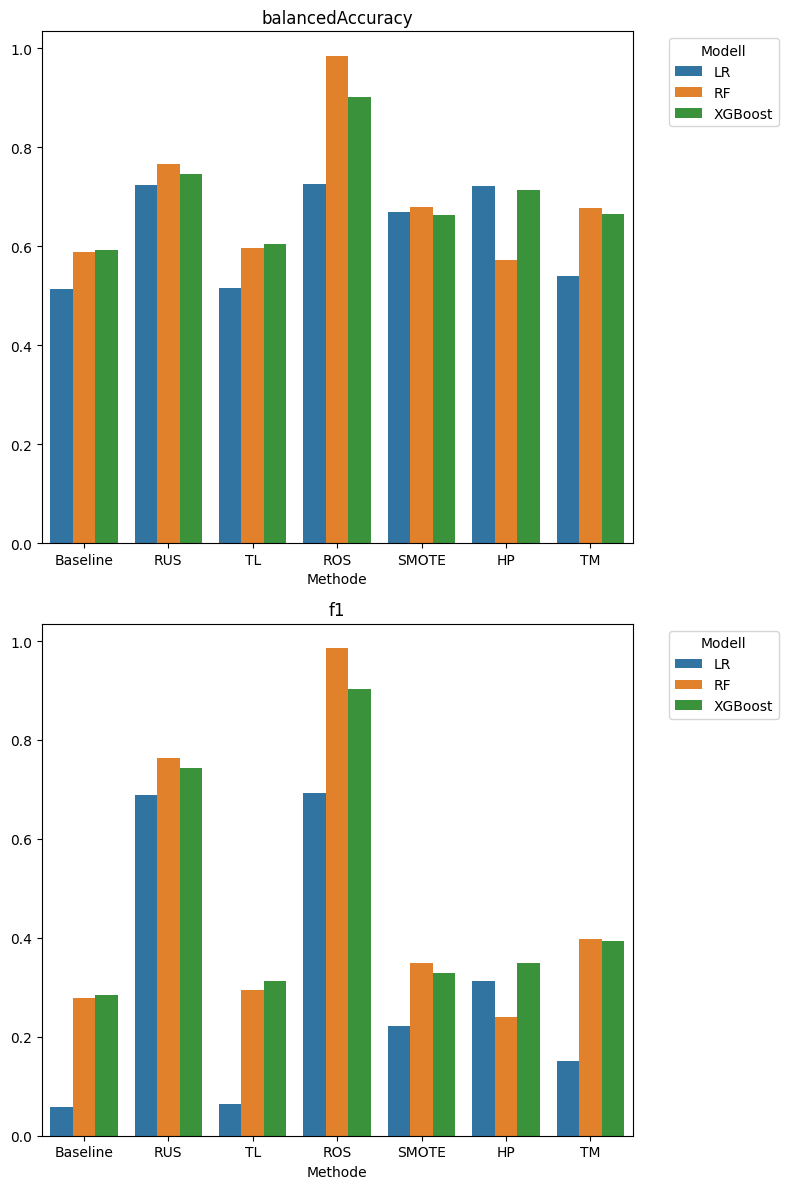

In [37]:
# Metriken-Liste 
metrics = ["balancedAccuracy", "f1"]

# Grafiken pro Metrik
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(8, 6 * len(metrics)))
for ax, i in zip(axes, metrics):
    sns.barplot(data=df_result, x="method", y=i, hue="model", order=resampling_methods, ax=ax)
    ax.set_title(i)
    ax.set_xlabel("Methode")
    ax.set_ylabel('')
    ax.legend(title="Modell", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# Gesamt-Grafik speichern
plt.savefig("output/evaluation_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

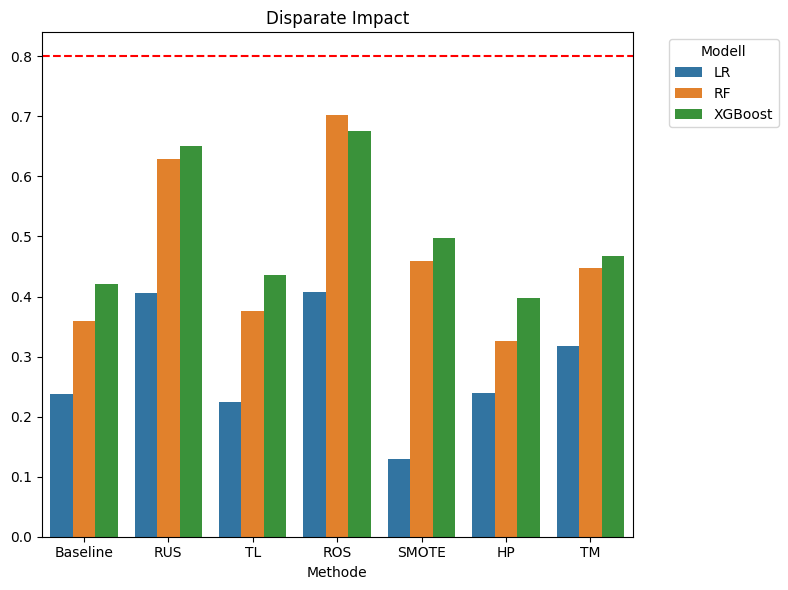

In [38]:
# Fairness-Metrik Disparate Impact Grafik 
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=df_result, x="method", y='dir', hue="model", order=resampling_methods, ax=ax)
ax.set_title('Disparate Impact')
ax.set_xlabel("Methode")
ax.set_ylabel('')
ax.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5)
ax.legend(title="Modell", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("output/evaluation_metrics_disparate_impact.png", dpi=300, bbox_inches="tight")
plt.show()

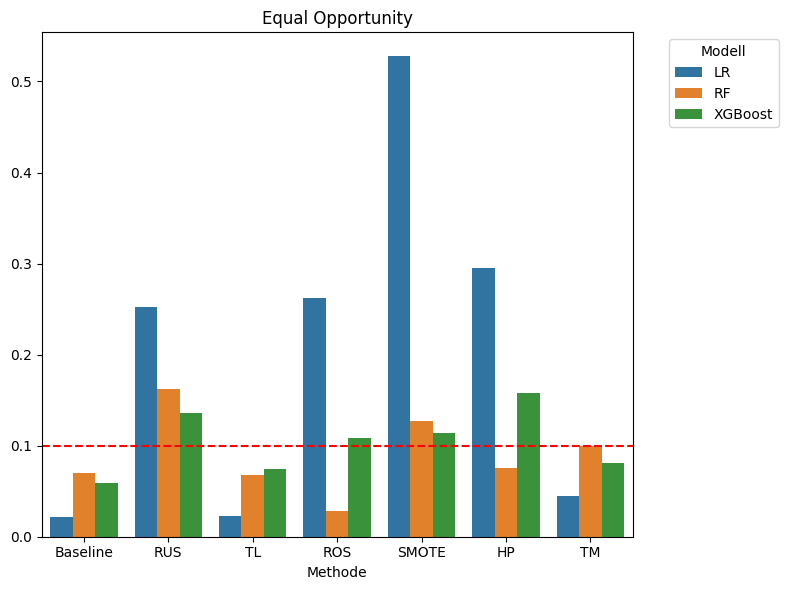

In [39]:
# Fairness-Metrik Equal Opportunity
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=df_result, x="method", y='eo', hue="model", order=resampling_methods, ax=ax)
ax.set_title('Equal Opportunity')
ax.set_xlabel("Methode")
ax.set_ylabel('')
ax.axhline(y=0.1, color='red', linestyle='--', linewidth=1.5)
ax.legend(title="Modell", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("output/evaluation_metrics_equal_opportunity.png", dpi=300, bbox_inches="tight")
plt.show()

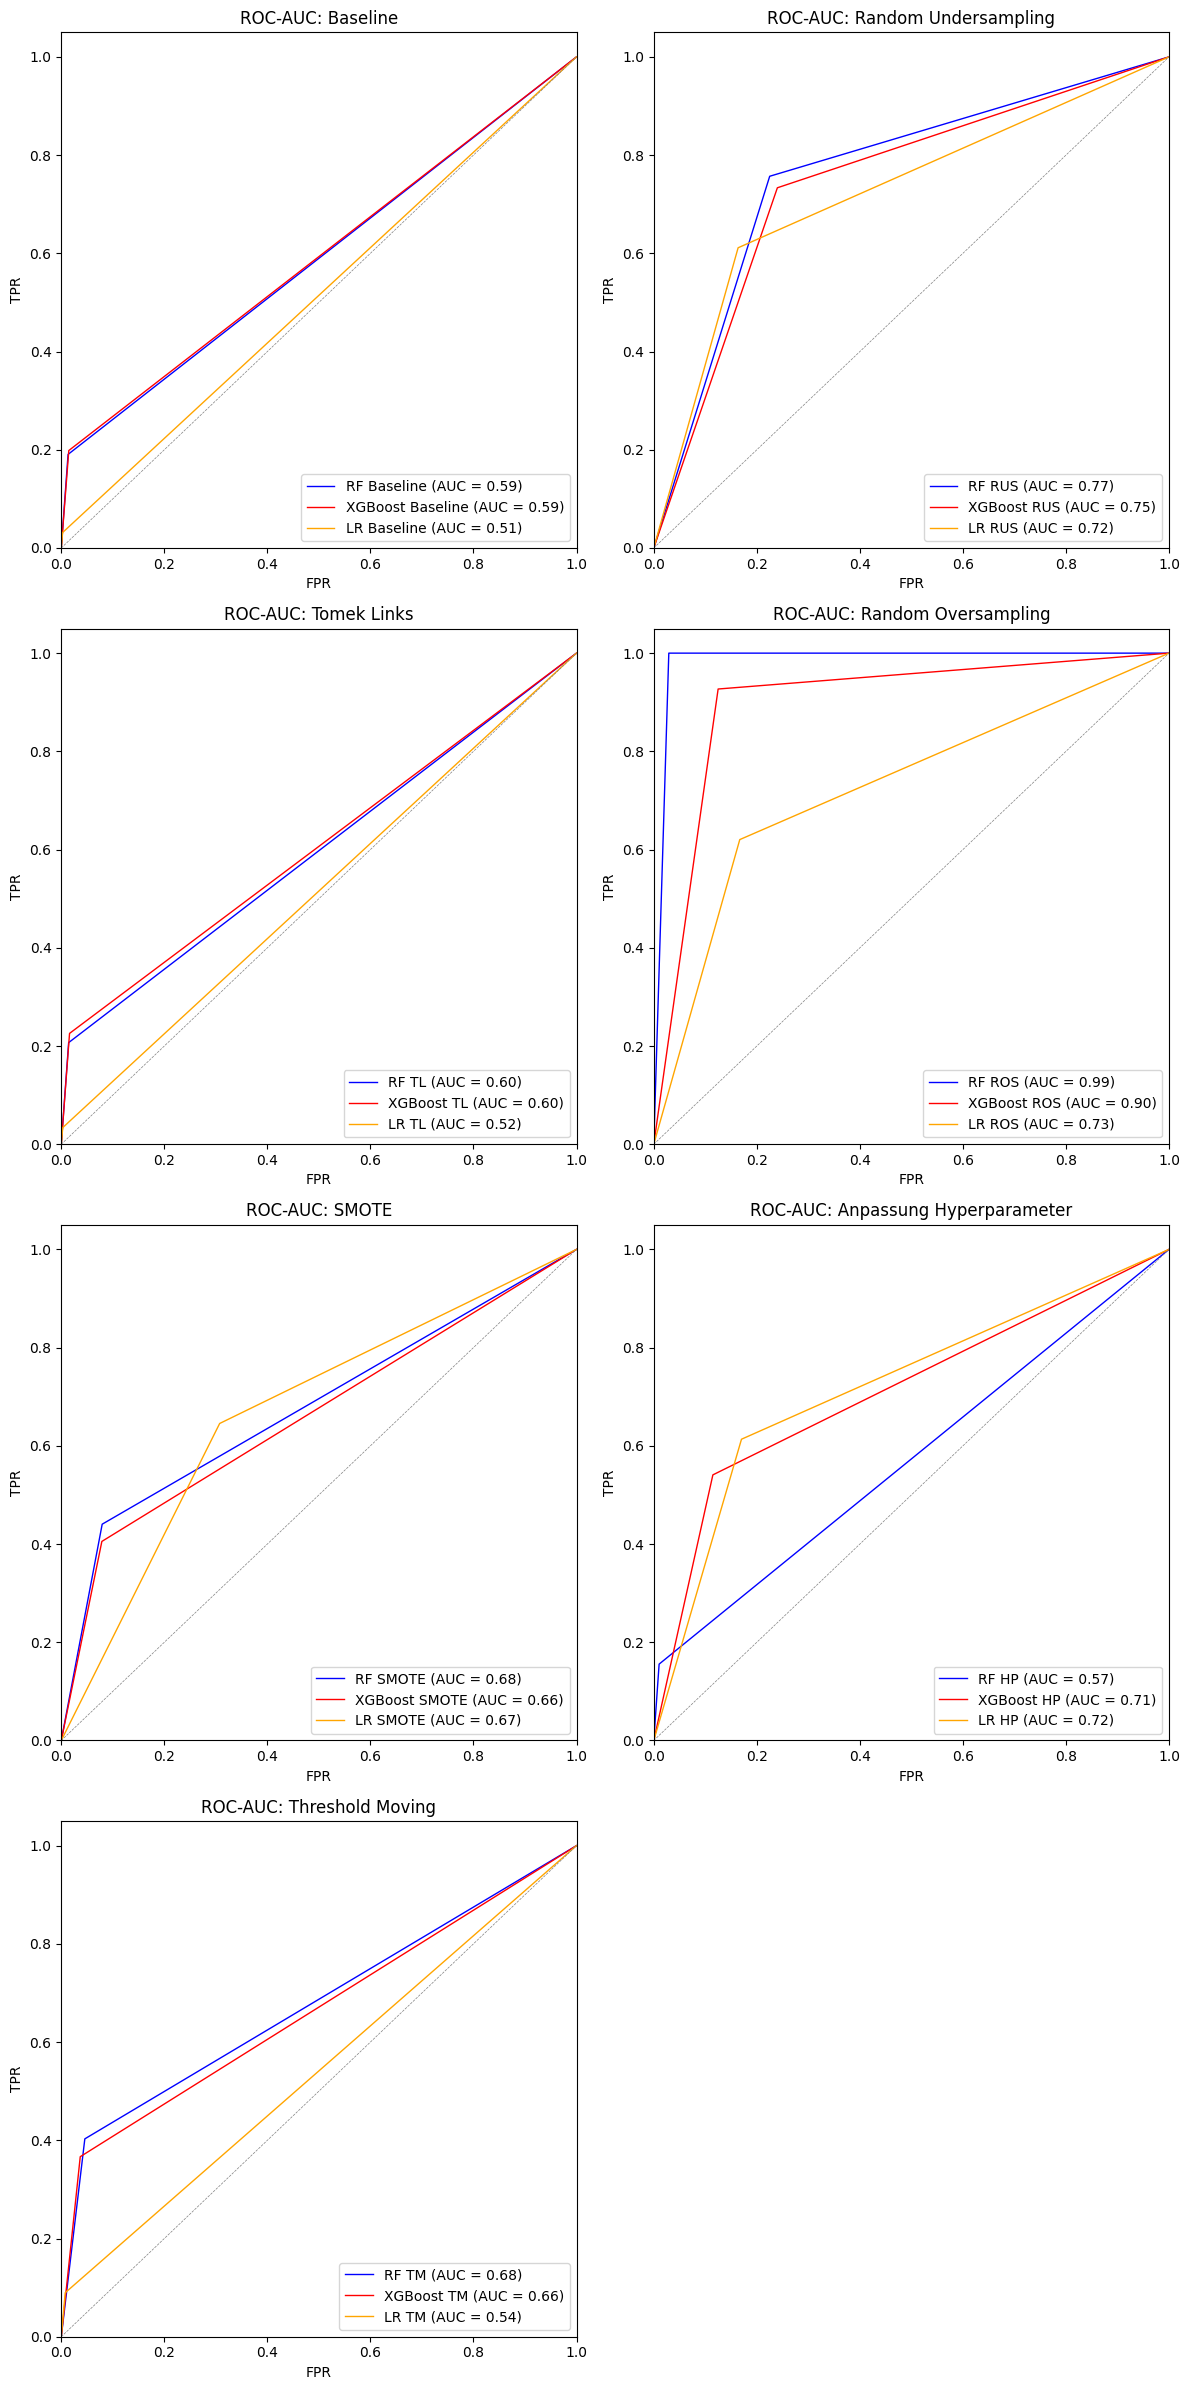

In [40]:
''' 
Funktion:       Erstellung ROC-AUC-Kurve für die verschiedenen Methoden zur Behebung unausgeglichener Daten
Input:          roc_data_list (roc_data)
                methodTitles (Methode zur Behebung unausgeglichener Daten für die Anzeige im Titel)
Funktionsweise: Basierend auf den gespeicherten ROC-Daten wird die ROC-AUC-Kurve für die drei ML-Modell pro Methode dargestellt.
'''
def plot_roc_curves(roc_data_list, methodTitles):
    num_plots = len(roc_data_list)
    num_cols = 2  
    num_rows = (num_plots + 1) // num_cols  
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
    axes = axes.flatten()  
    
    # Farben der einzelnen ML-Modelle festlegen
    colors = {
        'RF': 'blue',
        'XGBoost': 'red',
        'LR': 'orange'
    }
    
    # Pro Methode werden pro Modell die dazugehörige ROC-AUC-Kurve in die Grafik eingezeichnet
    for idx, (roc_data, methodTitles) in enumerate(zip(roc_data_list, methodTitles)):
        ax = axes[idx]
        
        for model_name, (fpr, tpr, auc) in roc_data.items():
            ax.plot(fpr, tpr, color=colors.get(model_name.split()[0], 'black'), lw=1,
                    label=f'{model_name} (AUC = {auc:.2f})')
        
        ax.plot([0, 1], [0, 1], color='gray', lw=0.5, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'ROC-AUC: {methodTitles}')
        ax.legend(loc="lower right")
    
    if num_plots % 2 != 0:
        fig.delaxes(axes[-1])
    
    plt.tight_layout()
    # Gesamt-Grafik speichern
    plt.savefig('output/evaluation_roc_auc.png', dpi=300, bbox_inches="tight")
    plt.show()
    

roc_data_list = [roc_data,  roc_data_rus, roc_data_tl, roc_data_ros, roc_data_smote, roc_data_hp, roc_data_tm] # ROC-Daten-Liste
titles = ['Baseline', 'Random Undersampling', "Tomek Links", 'Random Oversampling', 'SMOTE', 'Anpassung Hyperparameter', "Threshold Moving"] # Methodennamen-Liste
plot_roc_curves(roc_data_list, titles)

***
***